# Following tmic tutorial
https://lo.calho.st/posts/tdoa-multilateration/ 

In [18]:
#!pip install pymap3d

In [19]:
import numpy as np
import scipy.optimize as opt
import os
from pathlib import Path
import pymap3d as pm
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import contextily as ctx
from datetime import datetime, timedelta
from dataclasses import dataclass
from typing import Callable, List

# For north arrow & scale bar:
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


In [20]:
# Base directory from environment
BASE_DIR = os.getenv("BASE_DIR")
if not BASE_DIR:
    raise ValueError("BASE_DIR must be set")

# Find co-occuring blast events

### Calc a window to search over
We first figure out the distance and speed of sound so we have a reasonable time window to identify blast events that could be the same blast.

1. We calculate distance between two furthest recording points.
2. Then use speed of sound in this conditions to calculate travel time

For speed of sound, followed this webpage: http://resource.npl.co.uk/acoustics/techguides/soundseawater/. Used water temp = 28.5C, Salinity = 33.58 (taken from Rosalina et al., 2024 for the month of July in Spermonde in 2022*), Depth = 17m, Latitude = -4° 55' 47.712". Using the Mackenzie equation this gives 1541.007 m/s.

The study sites can be found here: https://www.google.com/maps/d/edit?mid=1etfYnjSsrtYnjrdnpzZR62knsrIj1t4&usp=sharing 


*SALINITY DISTRIBUTION PATTERN IN SPERMONDE WATERS USING REMOTE SENSING DATA (COPERNICUS MARINE SERVICE) IN 2022. (Google 'Spermonde salinity' to find this).

In [21]:
# Calc distance and travel time at 1541.007 m/s
# !pip install geopy


# Furthest apart recording sites
coord_a = (-4.70878, 119.32657)   # M35 Samatellu
coord_b = (-5.07711, 119.31749)   # M43 Barrang Caddi

SPEED_OF_SOUND = 1541.007  # Speed in metres per second

# Get furthest distance between any two recorders
distance_km = geodesic(coord_a, coord_b).kilometers
distance_m = distance_km * 1000

# Print
travel_time_s = distance_m / SPEED_OF_SOUND
print(f"Distance: {distance_km:.3f} km")
print(f"Travel time at {SPEED_OF_SOUND} m/s: {travel_time_s:.3f} s")


Distance: 40.743 km
Travel time at 1541.007 m/s: 26.439 s


### Calculate windows to check
This code reports possible detections of the same blast event if we use a reasonable time window for which we should check if blasts co-occur at the same time in different recorders.

To calc the reasonable window:
1. We used Hydromoths, for which Open Acoustics expect **clock drift** to be around 0.25sec per day: https://www.openacousticdevices.info/support/device-support/question-about-timing/dl-focus. We recorded on four unique days, so worst case scenario if one recorder drifted one way and another the opposite, that gives a 2sec misalignment. So, if a bomb was heard at the northern or southern most recorder, it would take 26.439 +- 2 second to reach the opposite recorder which is 28.439 sec maximum.
3. However, the **bomb model does not work on exact start timestamps for bombs**, it uses windows 2.88sec in length. So in theory, a timestamp given for a bomb may be 2.88sec earlier than the actual bomb (of course it would likely be less, but we take this maximum to be conservative). So we add this to get **31.319sec**.

In [22]:
# This cell loads bomb detection CSVs, computes full event timestamps,
# clusters events that fall within a defined time window,
# and prints out groups detected simultaneously across multiple recorders.


INPUT_PATH = Path(os.path.join(BASE_DIR, "bomb_fishing/data"))

# Maximum allowable difference between events to consider co-occurring
TIME_WINDOW_S: float = 31.319
window_delta: timedelta = timedelta(seconds=TIME_WINDOW_S)

@dataclass
class BombEvent:
    """
    Represents a single bomb detection event.

    Attributes:
        csv: Name of the CSV file where event was recorded
        file: WAV filename containing the timestamp reference
        timestamp: String HH:MM:SS offset into the WAV file
        when: Absolute datetime of the event
    """
    csv: str
    file: str
    timestamp: str
    when: datetime


def load_events(input_dir: Path) -> List[BombEvent]:
    """
    Load bomb events marked 'y' from CSVs, compute absolute timestamps.

    Returns list of BombEvent.
    """
    events: List[BombEvent] = []
    for csv_file in sorted(input_dir.glob("*.csv")):
        df = pd.read_csv(csv_file)
        df = df[df["Bomb"] == "y"].copy()
        if df.empty:
            continue
        # parse base datetime from filename prefix
        df["base_dt"] = (
            df["File"]
            .str.extract(r"(\d{8}_\d{6})")[0]
            .apply(lambda s: datetime.strptime(s, "%Y%m%d_%H%M%S"))
        )
        # get offset and compute absolute time
        df["offset"] = pd.to_timedelta(df["Timestamp (HH:MM:SS)"])
        df["when"] = df["base_dt"] + df["offset"]
        for row in df.itertuples():
            events.append(
                BombEvent(
                    csv=csv_file.name,
                    file=row.File,
                    timestamp=row._2,
                    when=row.when,
                )
            )
    return events


def cluster_events(events: List[BombEvent]) -> List[List[BombEvent]]:
    """
    Slide a window across sorted events, grouping events within window_delta.
    Picks the earliest event per CSV in each window and deduplicates clusters.
    """
    sorted_events = sorted(events, key=lambda e: e.when)
    clusters: List[List[BombEvent]] = []
    seen = set()
    start = 0
    for end, evt in enumerate(sorted_events):
        # advance start so window fits within time delta
        while sorted_events[end].when - sorted_events[start].when > window_delta:
            start += 1
        window = sorted_events[start:end+1]
        # select earliest event per CSV
        per_csv = {}
        for e in window:
            per_csv.setdefault(e.csv, e)
        if len(per_csv) >= 2:
            # build cluster sorted by time
            cluster = sorted(per_csv.values(), key=lambda x: x.when)
            # dedupe based on csv names and times
            key = tuple((e.csv, e.when.isoformat()) for e in cluster)
            if key not in seen:
                seen.add(key)
                clusters.append(cluster)
    return clusters


def print_clusters(clusters: List[List[BombEvent]]) -> None:
    """
    Print clusters by descending number of distinct CSV sources.
    """
    buckets = {4: [], 3: [], 2: []}
    for grp in clusters:
        count = len(grp)
        if count in buckets:
            buckets[count].append(grp)
    for count in (4, 3, 2):
        if not buckets[count]:
            continue
        print(f"\nEvents in {count} files:")
        for grp in buckets[count]:
            for e in grp:
                print(f"- {e.csv}: File={e.file}, Timestamp={e.timestamp}")
            print("---")

# Load and cluster events
events = load_events(INPUT_PATH)
if not events:
    print("No bomb events found in the directory.")
else:
    clusters = cluster_events(events)
    if clusters:
        print_clusters(clusters)
    else:
        print(f"No co-occurring events within {TIME_WINDOW_S} seconds.")


Events in 3 files:
- A_M35.csv: File=20240701_141200.WAV, Timestamp=00:00:14
- C_M41.csv: File=20240701_141200.WAV, Timestamp=00:00:14
- D_M43.csv: File=20240701_141200.WAV, Timestamp=00:00:25
---
- B_M36.csv: File=20240701_232301.wav, Timestamp=00:00:27
- C_M41.csv: File=20240701_232300.WAV, Timestamp=00:00:30
- A_M35.csv: File=20240701_232300.WAV, Timestamp=00:00:36
---
- B_M36.csv: File=20240702_002802.wav, Timestamp=00:00:31
- C_M41.csv: File=20240702_002800.WAV, Timestamp=00:00:34
- A_M35.csv: File=20240702_002800.WAV, Timestamp=00:00:38
---
- B_M36.csv: File=20240702_094501.wav, Timestamp=00:00:02
- C_M41.csv: File=20240702_094500.WAV, Timestamp=00:00:10
- D_M43.csv: File=20240702_094500.WAV, Timestamp=00:00:21
---
- B_M36.csv: File=20240702_111402.wav, Timestamp=00:00:00
- A_M35.csv: File=20240702_111401.WAV, Timestamp=00:00:04
- C_M41.csv: File=20240702_111400.WAV, Timestamp=00:00:08
---
- C_M41.csv: File=20240702_125900.WAV, Timestamp=00:00:00
- B_M36.csv: File=20240702_12590

### Stats test to check likelyhood suspected co-occuring blasts were just by chance
After checking the spectrograms, eight blast events were found which appear to have been detected by 3 different recorders within the same window. However, we need to check the probability this could happen by chance.

C M43, Bontosua, had the shortest recording time at 20240701_101100 to 20240704_104400. So we can use this as the most conservative (i.e)..

We run a permutation 'Monte-carlo' test to find the chances these 9 events would co-occur given the total time by:
- Randomly reassign each detection timestamp to a new location
    within the full recording window [0, T] (in seconds).
- Repeat this process `n_sims` times.
- For each shuffle, count how many events in array A have a
    corresponding event in both B and C within ± window seconds. 
    Which is still 31.319 and hence very conservative as it allows bombs to occur up to 62.6sec apart.
- Finally, return the proportion of shuffles that produced 9 or more
    triple-overlapping events.

In [23]:
# Stats test with expected overlaps and 95% CI

# Define recording window bounds explicitly
start_dt = datetime.strptime("20240701_101100", "%Y%m%d_%H%M%S")
end_dt   = datetime.strptime("20240704_104400", "%Y%m%d_%H%M%S")
T        = (end_dt - start_dt).total_seconds()

# Identify the three overlapping recorders (CSV names)
overlap_csvs = sorted({e.csv for grp in clusters for e in grp})[:3]

# Extract detection times (seconds from start) for each recorder
arrays = {
    name: np.array([(evt.when - start_dt).total_seconds()
                    for evt in events if evt.csv == name])
    for name in overlap_csvs
}
if len(arrays) < 3:
    raise RuntimeError("Need three overlapping recorders for Monte Carlo test.")

tA, tB, tC = (arrays[overlap_csvs[i]] for i in range(3))

# Monte Carlo permutations
n_sims = 100_000
counts = np.zeros(n_sims, dtype=int)

for i in range(n_sims):
    sA = np.random.rand(len(tA)) * T
    sB = np.random.rand(len(tB)) * T
    sC = np.random.rand(len(tC)) * T

    # count how many of A’s events co-occur in B and C within ±window
    cnt = sum(
        1 for x in sA
        if (np.any(np.abs(sB - x) <= TIME_WINDOW_S)
            and np.any(np.abs(sC - x) <= TIME_WINDOW_S))
    )
    counts[i] = cnt

# Observed count (We observed 8, but put 1 and then we can say chances 
# of 1 or more co-occuring to be conservative)
obs_count = 1

# p-value: fraction of sims with ≥ obs_count overlaps
p_val = np.mean(counts >= obs_count)

# Expected number of overlaps and 95% CI under null
mean_cnt   = counts.mean()
ci_lower, ci_upper = np.percentile(counts, [2.5, 97.5])

# Print results
print(f"Expected triple-overlaps under null: {mean_cnt:.5f}")
print(f"95% CI: {ci_lower:.5f}–{ci_upper:.5f}")
print(f"Observed {obs_count} overlaps, p-value = {p_val:.5f}")


Expected triple-overlaps under null: 0.00277
95% CI: 0.00000–0.00000
Observed 1 overlaps, p-value = 0.00277


# Blast localisation
First we provide the recorders coords and the arrival times. We then adjust the arrival times to account for the clock drift of each respective recorder to minimise error. We take each timestamp, find where it sits within the full recording duration, and adjust proportionally to this.

In [24]:
# Recorder positions (latitude, longitude) in WGS84 (EPSG:4326)
a_coords_geo = [
    (-4.70878, 119.32657),  # A
    (-4.80363, 119.32858),  # B
    (-4.92992, 119.31595),  # C
    #(-5.07711, 119.31749),  # D had no co-occuring dtections so we add later

]

# Time stamps for the 8 detections pulled out manually from the recordings
# Now clock drift synchronization is applied yet
raw_arrival_times = [
    [datetime(2024,7,1,23,23,36, 910000), # Recorder A
     datetime(2024,7,1,23,23,30, 729000), # Recorder B
     datetime(2024,7,1,23,23,31, 816000)], # Recorder C

    [datetime(2024,7,2,0,28,41,404000), 
     datetime(2024,7,2,0,28,35,247000), 
     datetime(2024,7,2,0,28,38,531000)],

    [datetime(2024,7,2,11,14,6,637000), 
     datetime(2024,7,2,11,14,2,842000), 
     datetime(2024,7,2,11,14,11,100000)],

    [datetime(2024,7,2,13,41,37,158000), 
     datetime(2024,7,2,13,41,31,740000), 
     datetime(2024,7,2,13,41,38,112000)],

    [datetime(2024,7,3,14,59,31,838000), 
     datetime(2024,7,3,14,59,26,932000), 
     datetime(2024,7,3,14,59,30,673000)],

    [datetime(2024,7,3,15,16,28,804000), 
     datetime(2024,7,3,15,16,23,904000), 
     datetime(2024,7,3,15,16,27,647000)],

    [datetime(2024,7,3,17,38,25,850000), 
     datetime(2024,7,3,17,38,21),      
     datetime(2024,7,3,17,38,23,639000)],

    [datetime(2024,7,4,4,49,31, 922000),       
     datetime(2024,7,4,4,49,27,702000),    
     datetime(2024,7,4,4,49,30,974000)]
]

##### Now adjust arrival times to account for clock drift

In [25]:
## Now adjust these arrival times to account for clock drift of each recorder
# When recorders were first synced
deployment_start = datetime(2024, 6, 28, 9, 5, 0)

# The synchronization time for each recorder at the end of the deployment 
# the diff is due to clock drift which we are going to account for
deployment_end_times = {
    "A": datetime(2024, 7, 5, 14, 46, 27, 690000),
    "B": datetime(2024, 7, 5, 14, 46, 27, 700000),
    "C": datetime(2024, 7, 5, 14, 46, 28, 130000),
}

# Compute the total offset at calibration, relative to A
labels = ["A","B","C"]
total_offsets = {
    lab: (deployment_end_times[lab] - deployment_end_times["A"]).total_seconds()
    for lab in labels
}

# Duration over which drift accrued:
total_driftspan = (deployment_end_times["A"] - deployment_start).total_seconds()

# Now we can correct the arrival times for each detection
arrival_times_adjusted = []
for times in raw_arrival_times:
    corrected = []
    for lab, t in zip(labels, times):
        # fraction of full drift that had happened by t:
        frac = (t - deployment_start).total_seconds() / total_driftspan
        # apply proportion of the total offset:
        shift_s = total_offsets[lab] * frac
        corrected.append(t - timedelta(seconds=shift_s))
    arrival_times_adjusted.append(corrected)

### Now implment the tutorial localisation

We have three recorders and we know when each one heard the same sound.
We can’t tell how far away the sound was, but we can tell which recorder heard it first, and how much earlier.

Since sound travels at a known speed, the difference in arrival time between two recorders tells us how much closer the sound must have been to one of them. That difference in distance is called a pseudodistance — it’s just: 
pseudodistance = speed_of_sound × time_difference

So, if Recorder A heard the sound 2 seconds before Recorder B, and sound travels at 1541 m/s, then the sound was about 3.08 km closer to A than B. This can be used to calculate a hyperbola, where all the points along this line satisfy that distance. Given we have 3 recorders, we calculate this for each combination and then find the points where they overlap.


make_tdoa_residuals()
- Takes coords of 3 recorders and psuedodistances between them given time of arrival and speed of sound.
- It returns a function that can take a candidate location (x, y) and checks "if the sound came from here, would the arrival times make sense?". It returns this error/the residuals.
- For a given candidate location it calculates the distance from each recorder for this candidate loc and, how well these distances satisfy the expected psuedo distance relationship given the 3 recorders loc
- Ouputs another function that outputs how well a candidate point fits the hyperbola contraints, proving the residuals

make_tdoa_jacobian()
- It tells the solver: "if I nudge the location a bit this way or that, how will the error change?". So it helps tell the solver which direction to walk.
- Gives the solver a map of how the residuals change when you slightly adjust (x, y).
- This map is called the Jacobian: a matrix that tells us the rate and direction of change for each residual as you move in x or y.


The residuals bit explained:

In [26]:
from IPython.display import display, Math

# LaTeX for the residual vector exactly as specified
equation = r"""
\begin{aligned}
r_{AB}(p)&=d(p,B)\;-\;d(p,A)\;-\;d_{AB},\\
r_{AC}(p)&=d(p,C)\;-\;d(p,A)\;-\;d_{AC},\\
r_{BC}(p)&=d(p,C)\;-\;d(p,B)\;-\;d_{BC},
\end{aligned}
\quad
\mathbf{r}(p)=
\begin{bmatrix}
r_{AB}(p)\\[3pt]
r_{AC}(p)\\[3pt]
r_{BC}(p)
\end{bmatrix},
"""

# Display the equation in Jupyter
display(Math(equation))


<IPython.core.display.Math object>

where

p=(x,y) is the candidate source location in our flat map.

A, B, C are the recorder positions in the same map.

d(p,X)=√((x - x_X)^2 + (y - y_X)^2) is the straight-line distance from p to recorder X.

d_XY=c*(t_Y - t_X) is the pseudodistance between recorders X and Y (sound speed c times the arrival-time difference).

---

What it means, step by step:

1. Compute pseudodistances d_AB, d_AC, d_BC from the time differences and sound speed.
2. Define three errors r_AB, r_AC, r_BC; each is zero when p lies exactly on that hyperbola.
3. Stack them into a 3-element vector r(p).
4. Find the p that makes all three errors as small as possible (via non-linear least squares).
5. Convert the best p back to latitude/longitude for your maps.

This keeps the maths minimal but clear: you only need the distance function and the pseudodistances.
"""

# Write the content to a text file
file_path = "/mnt/data/tdoa_methods.txt"
with open(file_path, "w") as f:
    f.write(content)

file_path


In [27]:
def make_tdoa_residuals(
    x0: float, y0: float,
    x1: float, y1: float,
    x2: float, y2: float,
    d01: float,
    d02: float,
    d12: float,
) -> Callable[[np.ndarray], np.ndarray]:
    """
    Build the TDOA hyperbola residuals for three observers.

    Observers at (x0,y0), (x1,y1), (x2,y2).
    Pseudodistances:
       d01 = c*(t1-t0),  d02 = c*(t2-t0),  d12 = c*(t2-t1).

    Returns a function f(vars) where vars = [x, y], such that:

      residuals = [
        sqrt((x-x1)²+(y-y1)²)
        - sqrt((x-x0)²+(y-y0)²)
        - d01,
      
        sqrt((x-x2)²+(y-y2)²)
        - sqrt((x-x0)²+(y-y0)²)
        - d02,
      
        sqrt((x-x2)²+(y-y2)²)
        - sqrt((x-x1)²+(y-y1)²)
        - d12,
      ]
    """
    def residuals(vars: np.ndarray) -> np.ndarray:
        x, y = vars
        # direct translation of tutorial’s three hyperbolae
        a = np.sqrt((x - x1)**2 + (y - y1)**2) \
          - np.sqrt((x - x0)**2 + (y - y0)**2) \
          - d01

        b = np.sqrt((x - x2)**2 + (y - y2)**2) \
          - np.sqrt((x - x0)**2 + (y - y0)**2) \
          - d02

        c = np.sqrt((x - x2)**2 + (y - y2)**2) \
          - np.sqrt((x - x1)**2 + (y - y1)**2) \
          - d12

        return np.array([a, b, c])
    return residuals


def make_tdoa_jacobian(
    x0: float, y0: float,
    x1: float, y1: float,
    x2: float, y2: float,
    d01: float,
    d02: float,
    d12: float,
) -> Callable[[np.ndarray], np.ndarray]:
    """
    Jacobian of the TDOA residual system above.
    Returns a function J(vars) giving a 3x2 matrix of partials.
    """
    def jacobian(vars: np.ndarray) -> np.ndarray:
        x, y = vars
        # distances
        r0 = np.hypot(x-x0, y-y0)
        r1 = np.hypot(x-x1, y-y1)
        r2 = np.hypot(x-x2, y-y2)

        # ∂a/∂x = (x−x1)/r1 − (x−x0)/r0,  ∂a/∂y = (y−y1)/r1 − (y−y0)/r0
        adx = (x-x1)/r1 - (x-x0)/r0
        ady = (y-y1)/r1 - (y-y0)/r0

        # ∂b/∂x = (x−x2)/r2 − (x−x0)/r0,  ∂b/∂y = (y−y2)/r2 − (y−y0)/r0
        bdx = (x-x2)/r2 - (x-x0)/r0
        bdy = (y-y2)/r2 - (y-y0)/r0

        # ∂c/∂x = (x−x2)/r2 − (x−x1)/r1,  ∂c/∂y = (y−y2)/r2 − (y−y1)/r1
        cdx = (x-x2)/r2 - (x-x1)/r1
        cdy = (y-y2)/r2 - (y-y1)/r1

        return np.array([
            [adx, ady],
            [bdx, bdy],
            [cdx, cdy],
        ])
    return jacobian


In [28]:
from typing import List, Dict

def solve_event_tdoa(
    coords_geo: List[tuple],
    times: List[datetime],
) -> Dict[str, float]:
    """
    Solve one blast event by nonlinear least-squares on three hyperbolae.

    Parameters
    coords_geo : list of (lat, lon) tuples for the 3 recorders
    times      : list of 3 datetime arrival times at each recorder

    Returns
    dict with keys 'lat' and 'lon' for the estimated source location
    """
    # Unpack geodetic recorder positions and times
    (lat0, lon0), (lat1, lon1), (lat2, lon2) = coords_geo
    t0, t1, t2 = times

    # Compute pseudodistances (meters)
    d01 = SPEED_OF_SOUND * (t1 - t0).total_seconds()
    d02 = SPEED_OF_SOUND * (t2 - t0).total_seconds()
    d12 = SPEED_OF_SOUND * (t2 - t1).total_seconds()

    # Convert geodetic → ENU (meters), centered at recorder 0
    e0, n0, _ = pm.geodetic2enu(lat0, lon0, 0, lat0, lon0, 0)
    e1, n1, _ = pm.geodetic2enu(lat1, lon1, 0, lat0, lon0, 0)
    e2, n2, _ = pm.geodetic2enu(lat2, lon2, 0, lat0, lon0, 0)

    # Initial guess = centroid of the three ENU points
    x0_init = float(np.mean([e0, e1, e2]))
    y0_init = float(np.mean([n0, n1, n2]))

    # Build residual and Jacobian functions
    residual_fn = make_tdoa_residuals(e0, n0, e1, n1, e2, n2, d01, d02, d12)
    jacobian_fn = make_tdoa_jacobian (e0, n0, e1, n1, e2, n2, d01, d02, d12)

    ### THIS IS THE KEY SOLVER BIT
    # Solve with scipy’s leastsq (returns (x,y), cov_x, info dict, msg, ier)
    solution, *rest= opt.leastsq(
        residual_fn,
        x0=[x0_init, y0_init],
        Dfun=jacobian_fn,
        full_output=True
    )
    x_sol, y_sol = solution

    # Convert back to geodetic
    lat_sol, lon_sol, _ = pm.enu2geodetic(x_sol, y_sol, 0, lat0, lon0, 0)

    # Return estimated coordinates as a dictionary
    return {"lat": lat_sol, "lon": lon_sol}

# Run for all events
estimates: List[Dict[str, float]] = []
for evt_idx, times in enumerate(arrival_times_adjusted, start=1):
    est = solve_event_tdoa(a_coords_geo, times)
    estimates.append({"event": evt_idx, **est})

df_est = pd.DataFrame(estimates)
df_est

,event,lat,lon
0,1,-4.856422,119.288671
1,2,-4.840248,119.295897
2,3,-4.788499,119.302310
3,4,-4.813192,119.297189
4,5,-4.828273,119.269808
5,6,-4.828216,119.269699
6,7,-4.836634,119.259424
7,8,-4.826708,119.250757


### Compute max hearing distance per blast #####

In [29]:
import math
# Haversine formula to compute great-circle distance (in meters)
def haversine(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
    R = 6_371_000  # Earth radius in meters
    φ1, φ2 = math.radians(lat1), math.radians(lat2)
    Δφ = math.radians(lat2 - lat1)
    Δλ = math.radians(lon2 - lon1)
    a = math.sin(Δφ/2)**2 + math.cos(φ1)*math.cos(φ2)*math.sin(Δλ/2)**2
    return 2 * R * math.atan2(math.sqrt(a), math.sqrt(1 - a))

# For each event, compute distance to each recorder and take the max
records = []
for _, row in df_est.iterrows():
    dists = [
        haversine(lat_r, lon_r, row.lat, row.lon)
        for lat_r, lon_r in a_coords_geo
    ]
    records.append({
        "event":          int(row.event),
        "max_distance_m": max(dists),
        **{f"dist_to_{lab}": d for lab, d in zip(["A","B","C"], dists)}
    })

df_dist = pd.DataFrame(records)
print(df_dist)

# Identify the single blast with the overall maximum hearing distance
top = df_dist.loc[df_dist["max_distance_m"].idxmax()]
print(f"\n→ Event {int(top.event)} has the greatest hearing range: "
      f"{top.max_distance_m/1000:.2f} km")


   event  max_distance_m     dist_to_A    dist_to_B     dist_to_C
0      1    16945.650585  16945.650585  7349.325213   8713.508152
1      2    15008.502580  15008.502580  5449.157222  10215.595882
2      3    15797.718140   9263.075450  3362.139407  15797.718140
3      4    13144.981058  12057.905529  3637.106022  13144.981058
4      5    14700.490954  14700.490954  7065.036013  12405.005144
5      6    14699.945783  14699.945783  7073.733819  12415.763858
6      7    16046.042778  16046.042778  8496.127609  12116.853022
7      8    15573.228296  15573.228296  8996.734655  13560.356187

→ Event 1 has the greatest hearing range: 16.95 km


### Maps

In [30]:
def add_north_arrow(ax, location="upper left", size=0.08):
    """
    Add a north‐arrow icon at the specified location (axes‐fraction).
    location: 'upper left' | 'upper right' | 'lower left' | 'lower right'
    size: zoom factor for the PNG.
    """
    pos_map = {
        "upper left":  (0.1, 0.9),
        "upper right": (0.9, 0.9),
        "lower left":  (0.03, 0.01),
        "lower right": (0.9, 0.1),
    }
    loc = pos_map.get(location.lower(), pos_map["upper left"])
    # (Keep exactly your existing arrow‐image path)
    arrow_path = os.path.join(BASE_DIR, "marrs_acoustics/data/figures/north_arrow_pixabay.png")
    img = mpimg.imread(arrow_path)
    imgbox = OffsetImage(img, zoom=size)
    ab = AnnotationBbox(imgbox, loc, xycoords="axes fraction", frameon=False)
    ax.add_artist(ab)

def add_scalebar(ax, length, location="lower left", tick_count=4, thickness=2, labelsize=10):
    """
    Draw a scale bar of 'length' meters at the given axes‐fraction location.
    tick_count: how many tick marks (including endpoints).
    thickness: line thickness in data units.
    labelsize: font size for the "X km" label.
    """
    pos_map = {
        "lower left":  (-0.03, -0.01),
        "lower right": (0.95, 0.05),
        "upper left":  (0.05, 0.95),
        "upper right": (0.95, 0.95),
    }
    loc_frac = pos_map.get(location.lower(), pos_map["lower left"])
    # Convert that fraction into data coords
    disp_start = ax.transAxes.transform(loc_frac)
    data_start = ax.transData.inverted().transform(disp_start)
    x0, y0 = data_start[0], data_start[1]

    # Draw the main horizontal bar
    ax.plot([x0, x0 + length], [y0, y0], color="black", linewidth=thickness, zorder=10)
    # Draw equally spaced tick marks (vertical lines)
    for i in range(tick_count):
        tick_x = x0 + i * (length / (tick_count - 1))
        tick_px = ax.transData.transform((tick_x, y0))
        tick_end_px = (tick_px[0], tick_px[1] - 10)  # 10 px down
        tick_data_end = ax.transData.inverted().transform(tick_end_px)
        tick_len = y0 - tick_data_end[1]
        ax.plot([tick_x, tick_x], [y0, y0 - tick_len], color="black", linewidth=thickness, zorder=10)

    # Label the midpoint (in km)
    mid_x = x0 + (length / 2)
    ax.text(
        mid_x,
        y0 + (tick_len * 1.2),
        f"{length/1000:.1f} km",
        ha="center",
        va="bottom",
        fontsize=labelsize,
        fontweight="bold",
        zorder=10
    )

def make_x_formatter(decimals=2):
    """Format Web-Mercator x (m) → longitude (°)."""
    def formatter(x, pos):
        lon = (x / 6378137.0) * (180.0 / math.pi)
        return f"{lon:.{decimals}f}°"
    return formatter

def make_y_formatter(decimals=2):
    """Format Web-Mercator y (m) → latitude (°)."""
    def formatter(y, pos):
        lat = (math.pi/2 - 2 * math.atan(math.exp(-y / 6378137.0))) * (180.0 / math.pi)
        return f"{lat:.{decimals}f}°"
    return formatter

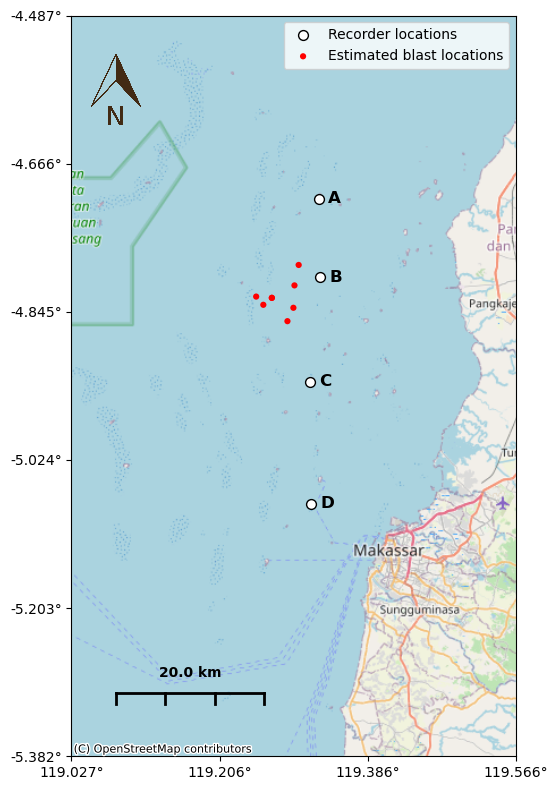

In [35]:
# Recording-site coords, converted to Web-Mercator (EPSG:3857)
rec_gdf = gpd.GeoDataFrame(
    {"label":["A","B","C"]},
    geometry=[Point(lon, lat) for lat,lon in a_coords_geo],
    crs="EPSG:4326"
).to_crs(epsg=3857)

# Now Add recorder D in 4326 for plotting and convert to 3857
lat_d, lon_d = -5.07711, 119.31749
gdf_d = gpd.GeoDataFrame(
    {"label": ["D"]},
    geometry=[Point(lon_d, lat_d)],
    crs="EPSG:4326",
).to_crs(epsg=3857)
# concatenate
rec_gdf = pd.concat([rec_gdf, gdf_d], ignore_index=True)

# Set the blast locatiions
src_gdf = gpd.GeoDataFrame(
    df_est,
    geometry=[Point(lon, lat) for lat,lon in zip(df_est.lat, df_est.lon)],
    crs="EPSG:4326"
).to_crs(epsg=3857)

# plot
fig, ax = plt.subplots(figsize=(8,8))


# recorders (all use the same legend entry)
rec_gdf.plot(ax=ax, marker="o", facecolor="white", edgecolor="black", markersize=50, label="Recorder locations")
src_gdf.plot(ax=ax, marker="o", facecolor="red", edgecolor="none", markersize=20, label="Estimated blast locations")

# annotate each recorder with its label and jitter label position
dx = 1200  # label offset to right in metrees
for _, row in rec_gdf.iterrows():
    ax.text(
        row.geometry.x + dx,
        row.geometry.y,
        row["label"],
        color="black",
        fontsize=12,
        fontweight="bold",
        ha="left",    # align text to the left of its anchor
        va="center",
    )

# Zoom
zoom_amount = 0.6
xmin, ymin, xmax, ymax = rec_gdf.total_bounds
buf = max(xmax - xmin, ymax - ymin) * zoom_amount
ax.set_xlim(xmin - buf, xmax + buf)
ax.set_ylim(ymin - buf, ymax + buf)


# Basemap 
provider = ctx.providers.OpenStreetMap.Mapnik #CAT
ctx.add_basemap(ax, source=provider, crs="EPSG:3857")

# Add north arrow 
add_north_arrow(ax, location="upper left", size=0.04)

# Add scale bar
SCALE_BAR_LEN = 20_000  # in metres
add_scalebar(ax, length=SCALE_BAR_LEN, location="lower left", tick_count=4)

# Enable lat/lon tick labels on the existing axes ===
# Turn the axes back on so tick lines appear:
ax.set_axis_on()
ax.xaxis.set_ticks_position("bottom")
ax.yaxis.set_ticks_position("left")
ax.tick_params(axis="both", labelsize=10)

# Format ticks as degrees:
ax.xaxis.set_major_formatter(mticker.FuncFormatter(make_x_formatter(decimals=3)))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(make_y_formatter(decimals=3)))

# Show only every second tick on x axis to avoid clutter
xticks = ax.get_xticks()
ax.set_xticks(xticks[::2])
yticks = ax.get_yticks()
ax.set_yticks(yticks[::1])

# Legend and final layout 
ax.legend(loc="upper right", fontsize=10)
#ax.set_axis_off()  # hides only the frame, but keeps tick labels
plt.tight_layout()
plt.tight_layout()
save_path = os.path.join(BASE_DIR, "bomb_fishing/data/figures", f"localisation_left.png")
plt.savefig(save_path, dpi=600, bbox_inches="tight", transparent=True)
plt.show()

#### Plot hyperbola 
We can see the solver picked a location very close to the intersection of the hyperbola.

/tmp/ipykernel_4451/4128180041.py:149: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc="upper right", fontsize=10)


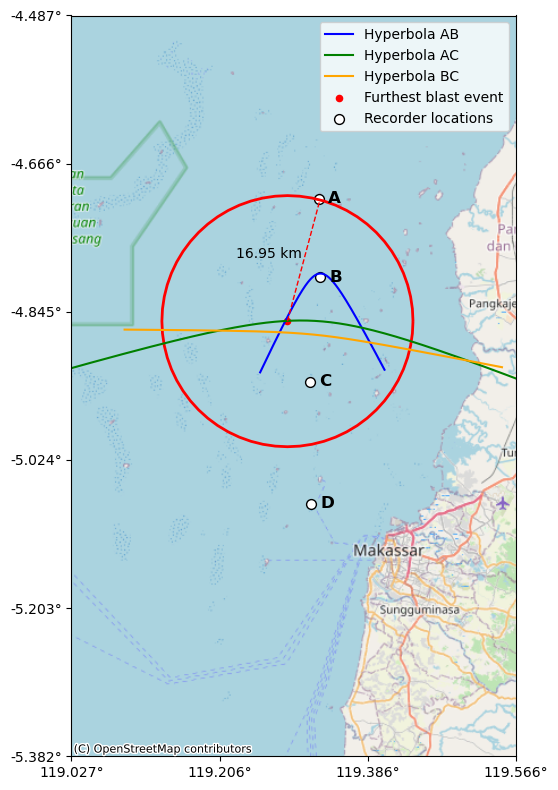

In [32]:
# Plot hyperbolae for the blast heard furthest away 
from math import sqrt

# Helper to generate the two branches of a hyperbola in Web-Mercator metres
def gen_hyperbola_branches(f1, f2, delta, num=400):
    """
    f1, f2: (x,y) of two recorders in metres (Web-Mercator)
    delta: pseudodistance = c * (t2–t1) in metres
    Returns: [branch_pos (num×2), branch_neg (num×2)]
    """
    x1, y1 = f1
    x2, y2 = f2
    half_base = np.hypot(x2 - x1, y2 - y1) / 2
    a = abs(delta) / 2
    b = sqrt(max(half_base**2 - a**2, 0))
    xc, yc = (x1 + x2) / 2, (y1 + y2) / 2
    θ = np.arctan2(y2 - y1, x2 - x1)
    u = np.linspace(-2, 2, num)
    branches = []
    for sign in (+1, -1):
        xp = sign * a * np.cosh(u)
        yp = b * np.sinh(u)
        xr = xc + xp * np.cos(θ) - yp * np.sin(θ)
        yr = yc + xp * np.sin(θ) + yp * np.cos(θ)
        branches.append(np.vstack((xr, yr)).T)
    return branches

# Which event to plot?
event_to_plot = int(top.event)  # from Cell 5

# Recorder positions in Web-Mercator (already in rec_gdf)
foci = list(zip(rec_gdf.geometry.x, rec_gdf.geometry.y))

# Arrival times for that event (clock-drift–adjusted)
times = arrival_times_adjusted[event_to_plot - 1]

# Compute pseudodistances (in metres)
AB = SPEED_OF_SOUND * ( (times[1] - times[0]).total_seconds() )
AC = SPEED_OF_SOUND * ( (times[2] - times[0]).total_seconds() )
BC = SPEED_OF_SOUND * ( (times[2] - times[1]).total_seconds() )

# Generate hyperbola branches
ab_pos, ab_neg = gen_hyperbola_branches(foci[0], foci[1], AB)
ac_pos, ac_neg = gen_hyperbola_branches(foci[0], foci[2], AC)
cb_pos, cb_neg = gen_hyperbola_branches(foci[1], foci[2], BC)

# Plot
fig, ax = plt.subplots(figsize=(8, 8))

# Hyperbola AB
ax.plot(ab_pos[:,0], ab_pos[:,1], color="blue", label="Hyperbola AB")
#ax.plot(ab_neg[:,0], ab_neg[:,1], color="blue") #Hide the hyperbola that doesn't overlap

# Hyperbola AC
ax.plot(ac_pos[:,0], ac_pos[:,1], color="green", label="Hyperbola AC")
#ax.plot(ac_neg[:,0], ac_neg[:,1], color="green") #Hide the hyperbola that doesn't overlap

# Hyperbola BC
ax.plot(cb_pos[:,0], cb_pos[:,1], color="orange", label="Hyperbola BC")

# Gte max estimated source and plot it
src_pt = src_gdf[src_gdf["event"] == event_to_plot].geometry.iloc[0]
ax.scatter( src_pt.x, src_pt.y, marker="o", s=20, color="red", label=f"Furthest blast event")

# Plot recorders as above for previous cell
rec_gdf.plot(ax=ax, marker="o", facecolor="white", edgecolor="black", markersize=50, label="Recorder locations")

# annotate each recorder with its label and jitter label position
dx = 1200  # label offset to right in metrees
for _, row in rec_gdf.iterrows():
    ax.text(
        row.geometry.x + dx,
        row.geometry.y,
        row["label"],
        color="black",
        fontsize=12,
        fontweight="bold",
        ha="left",    # align text to the left of its anchor
        va="center",
    )

### Add radius
# Radius in metres
radius_m = 16.95 * 1000  # 16.95 km
# Center point of the furthest blast, already in Web‐Mercator
center = src_pt  # a shapely Point in EPSG:3857
# Build the circle geometry
circle = center.buffer(radius_m)

# Plot the empty circle with red dashed outline
gpd.GeoSeries([circle], crs="EPSG:3857").plot(
    ax=ax,
    edgecolor="red",
    facecolor="none",
    linewidth=2,
    linestyle="-",
    label="16.95 km radius",
)

# Draw a dashed red radius line at a 320° angle above horizontal
x0, y0 = center.x, center.y
angle = np.deg2rad(75)          # tilt angle (in radians)
dx = radius_m * np.cos(angle)   # horizontal component
dy = radius_m * np.sin(angle)   # vertical component
x1, y1 = x0 + dx, y0 + dy

ax.plot([x0, x1], [y0, y1],
        color="red",
        linestyle="--",
        linewidth=1)

# Label at the midpoint of the tilted line (and shift a bit left)
mid_x, mid_y = x0 + ((dx/2)-200), y0 + dy/2
ax.text(mid_x, mid_y,
        "16.95 km",
        color="black",
        fontsize=10,
        ha="right",    # align text to the left of its anchor
        va="bottom")  # put text just above the line

# Zoom to include all recorders + hyperbolae
xmin, ymin, xmax, ymax = rec_gdf.total_bounds
buf = max(xmax - xmin, ymax - ymin) *zoom_amount
ax.set_xlim(xmin - buf, xmax + buf)
ax.set_ylim(ymin - buf, ymax + buf)

# Basemap
provider = ctx.providers.OpenStreetMap.Mapnik #CAT
ctx.add_basemap(ax, source=provider, crs="EPSG:3857")

# Enable lat/lon tick labels on the existing axes ===
# Turn the axes back on so tick lines appear:
ax.set_axis_on()
ax.xaxis.set_ticks_position("bottom")
ax.yaxis.set_ticks_position("left")
ax.tick_params(axis="both", labelsize=10)

# Format ticks as degrees:
ax.xaxis.set_major_formatter(mticker.FuncFormatter(make_x_formatter(decimals=3)))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(make_y_formatter(decimals=3)))

# Show only every second tick on x axis to avoid clutter
xticks = ax.get_xticks()
ax.set_xticks(xticks[::2])
yticks = ax.get_yticks()
ax.set_yticks(yticks[::1])

# Legend and final layout 
ax.legend(loc="upper right", fontsize=10)
#ax.set_axis_off()  # hides only the frame, but keeps tick labels
plt.tight_layout()
save_path = os.path.join(BASE_DIR, "bomb_fishing/data/figures", f"localisation_right.png")
plt.savefig(save_path, dpi=600, bbox_inches="tight", transparent=True)
plt.show()

#### TODO
- Add coords around map axis
- Choose which map to present in manuscript

### Trying to choose basemap
Only OpenStreetMap seems reliable. CAT or BZH seem to have less fluff like roads, airpots and other random lines crossing the water.

In [33]:
import contextily as ctx
print(list(ctx.providers.keys()))


['OpenStreetMap', 'MapTilesAPI', 'OpenSeaMap', 'OPNVKarte', 'OpenTopoMap', 'OpenRailwayMap', 'OpenFireMap', 'SafeCast', 'Stadia', 'Thunderforest', 'BaseMapDE', 'CyclOSM', 'Jawg', 'MapBox', 'MapTiler', 'TomTom', 'Esri', 'OpenWeatherMap', 'HERE', 'HEREv3', 'FreeMapSK', 'MtbMap', 'CartoDB', 'HikeBike', 'BasemapAT', 'nlmaps', 'NASAGIBS', 'NLS', 'JusticeMap', 'GeoportailFrance', 'OneMapSG', 'USGS', 'WaymarkedTrails', 'OpenAIP', 'OpenSnowMap', 'AzureMaps', 'SwissFederalGeoportal', 'TopPlusOpen', 'Gaode', 'Strava', 'OrdnanceSurvey', 'UN']


In [34]:
ctx.providers.OpenStreetMap.keys()

dict_keys(['Mapnik', 'DE', 'CH', 'France', 'HOT', 'BZH', 'CAT'])